In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv, yv, sph_harm, ellipj, ellipkinc, ellipeinc
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models



In [2]:
# Corrected definition for inner networks (ψ_qp)
def create_inner_network(hidden_units):
    inputs = layers.Input(shape=(1,))
    x = layers.Dense(hidden_units, activation="relu")(inputs)
    x = layers.Dense(hidden_units, activation="relu")(x)
    outputs = layers.Dense(1)(x)
    return models.Model(inputs, outputs, name="Inner_Network")


In [3]:
# Define the outer networks (Φ_q)
def create_outer_network(hidden_units):
    inputs = layers.Input(shape=(1,))
    x = layers.Dense(hidden_units, activation="relu")(inputs)
    x = layers.Dense(hidden_units, activation="relu")(x)
    outputs = layers.Dense(1)(x)
    return models.Model(inputs, outputs, name="Outer_Network")


In [4]:
class KolmogorovArnoldNetwork(tf.keras.Model):
    def __init__(self, input_dim, num_outer, hidden_units_inner, hidden_units_outer):
        super(KolmogorovArnoldNetwork, self).__init__()
        self.inner_networks = [
            create_inner_network(hidden_units_inner) for _ in range(input_dim)
        ]
        self.outer_networks = [
            create_outer_network(hidden_units_outer) for _ in range(num_outer)
        ]

    def call(self, inputs):
        # Compute inner sums (ψ_qp)
        inner_sums = []
        for i in range(len(self.outer_networks)):
            inner_sum = tf.add_n(
                [self.inner_networks[j](inputs[:, j:j+1]) for j in range(len(self.inner_networks))]
            )
            inner_sums.append(inner_sum)
        
        # Compute outer functions (Φ_q)
        outer_sums = tf.add_n(
            [self.outer_networks[k](inner_sums[k]) for k in range(len(self.outer_networks))]
        )
        return outer_sums


In [5]:
# Generate a dataset for the Bessel function
def generate_bessel_dataset(n_samples=5000):
    np.random.seed(42)
    # Randomly sample ν and x
    ν = np.random.uniform(0, 10, n_samples)
    x = np.random.uniform(0, 10, n_samples)
    y = jv(ν, x)  # Compute the Bessel function values
    return np.vstack([ν, x]).T, y

# Generate the dataset
X, y = generate_bessel_dataset()

# Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [8]:
kan_model = KolmogorovArnoldNetwork(
    input_dim=2,  # ν and x
    num_outer=5,  # Width of outer networks
    hidden_units_inner=32,
    hidden_units_outer=16
)

# Compile and train
kan_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
history = kan_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0362 - mse: 0.0362 - val_loss: 0.0271 - val_mse: 0.0271
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 0.0221 - mse: 0.0221 - val_loss: 0.0221 - val_mse: 0.0221
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 0.0180 - mse: 0.0180 - val_loss: 0.0202 - val_mse: 0.0202
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 0.0154 - mse: 0.0154 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 9/100
110/110 ━━━━━━━━━━━━━━━━

In [9]:
from sklearn.neural_network import MLPRegressor

# Example: MLP with depth=4 and width=100
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)
y_mlp_pred = mlp_model.predict(X_test)
mlp_rmse = mean_squared_error(y_test, y_mlp_pred, squared=False)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [10]:
from tensorflow.keras.regularizers import l1

# Example: Adding sparsity
kan_model_with_pruning = KolmogorovArnoldNetwork(
    input_dim=2,
    num_outer=5,
    hidden_units_inner=32,
    hidden_units_outer=16
)

# Add L1 regularization
for layer in kan_model_with_pruning.layers:
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = l1(1e-3)

# Train the sparsified model
kan_model_with_pruning.compile(optimizer='adam', loss='mse', metrics=['mse'])
kan_model_with_pruning.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)


Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0198 - mse: 0.0198 - val_loss: 0.0157 - val_mse: 0.0157
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 9/100
110/110 ━━━━━━━━━━━━━━━━

In [11]:
kan_params = kan_model.count_params()
mlp_params = sum(param.size for param in mlp_model.coefs_)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Performance Summary:
KAN: RMSE = 0.0513, Parameters = 3911
MLP: RMSE = 0.0160, Parameters = 30300


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


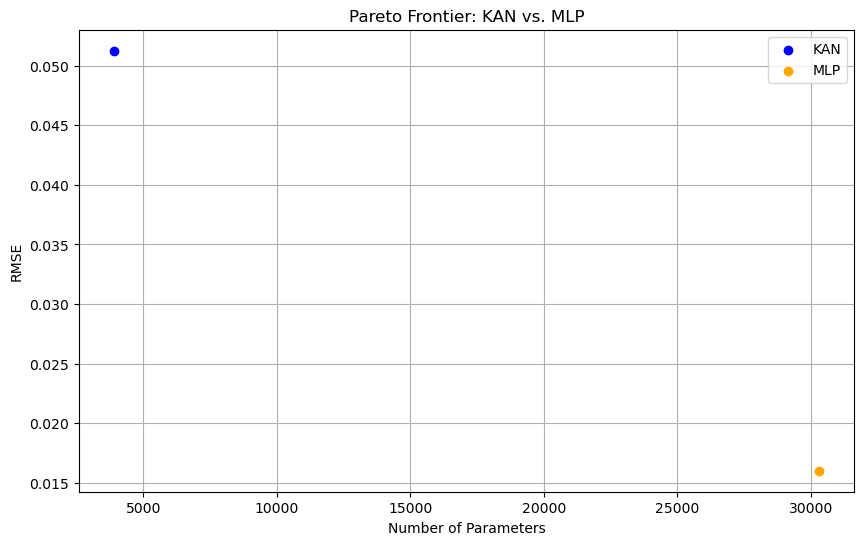

In [14]:
from sklearn.metrics import mean_squared_error

# Predict on the test set for KAN
y_kan_pred = kan_model.predict(X_test)

# Compute RMSE
kan_rmse = mean_squared_error(y_test, y_kan_pred, squared=False)
mlp_rmse = mean_squared_error(y_test, y_mlp_pred, squared=False)

# Compute number of parameters
kan_params = kan_model.count_params()
mlp_params = sum(param.size for param in mlp_model.coefs_)  # MLP parameters in scikit-learn

# Print results
print("Performance Summary:")
print(f"KAN: RMSE = {kan_rmse:.4f}, Parameters = {kan_params}")
print(f"MLP: RMSE = {mlp_rmse:.4f}, Parameters = {mlp_params}")

# Plot Pareto Frontier
plt.figure(figsize=(10, 6))
plt.scatter(kan_params, kan_rmse, label="KAN", color='blue')
plt.scatter(mlp_params, mlp_rmse, label="MLP", color='orange')
plt.xlabel("Number of Parameters")
plt.ylabel("RMSE")
plt.title("Pareto Frontier: KAN vs. MLP")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# Example: Train KAN with increasing grid resolution
grid_points = [3, 5, 10, 20, 50, 100, 200]
for G in grid_points:
    # Update KAN with new grid resolution
    kan_model = KolmogorovArnoldNetwork(input_dim=2, num_outer=5, hidden_units_inner=G, hidden_units_outer=16)
    kan_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    print(f"Training KAN with grid resolution G={G}")
    kan_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)
    # Evaluate
    y_pred = kan_model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"RMSE with G={G}: {rmse:.6f}")


Training KAN with grid resolution G=3
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE with G=3: 0.070467
Training KAN with grid resolution G=5


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE with G=5: 0.202767
Training KAN with grid resolution G=10


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE with G=10: 0.065566
Training KAN with grid resolution G=20


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE with G=20: 0.179899
Training KAN with grid resolution G=50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE with G=50: 0.053660
Training KAN with grid resolution G=100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE with G=100: 0.055821
Training KAN with grid resolution G=200


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE with G=200: 0.165270


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [16]:
from tensorflow.keras.regularizers import l1

# Add L1 regularization to inner and outer networks
for layer in kan_model.layers:
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = l1(1e-3)

# Retrain the KAN model
kan_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
kan_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)


Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0252 - mse: 0.0252 - val_loss: 0.0295 - val_mse: 0.0295
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0251 - mse: 0.0251 - val_loss: 0.0278 - val_mse: 0.0278
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0252 - mse: 0.0252 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0257 - mse: 0.0257 - val_loss: 0.0287 - val_mse: 0.0287
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0252 - mse: 0.0252 - val_loss: 0.0288 - val_mse: 0.0288
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0266 - mse: 0.0266 - val_loss: 0.0291 - val_mse: 0.0291
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0246 - mse: 0.0246 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0286 - val_mse: 0.0286
Epoch 9/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

In [17]:
for depth in [2, 3, 4, 5, 6]:
    for width in [5, 10, 20]:
        print(f"Training KAN with depth={depth}, width={width}")
        kan_model = KolmogorovArnoldNetwork(input_dim=2, num_outer=width, hidden_units_inner=32, hidden_units_outer=16)
        kan_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
        kan_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)
        # Evaluate
        y_pred = kan_model.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        print(f"RMSE: {rmse:.6f}")


Training KAN with depth=2, width=5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE: 0.178361
Training KAN with depth=2, width=10


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
RMSE: 0.059241
Training KAN with depth=2, width=20


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
RMSE: 0.055196
Training KAN with depth=3, width=5


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE: 0.071027
Training KAN with depth=3, width=10


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
RMSE: 0.054323
Training KAN with depth=3, width=20


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
RMSE: 0.062266
Training KAN with depth=4, width=5


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE: 0.180750
Training KAN with depth=4, width=10


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
RMSE: 0.055946
Training KAN with depth=4, width=20


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
RMSE: 0.059775
Training KAN with depth=5, width=5


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE: 0.053208
Training KAN with depth=5, width=10


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
RMSE: 0.178005
Training KAN with depth=5, width=20


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
RMSE: 0.052993
Training KAN with depth=6, width=5


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE: 0.055020
Training KAN with depth=6, width=10


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
RMSE: 0.067154
Training KAN with depth=6, width=20


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
RMSE: 0.187884


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [19]:
from sklearn.metrics import mean_squared_error

kan_params_list = []
kan_rmse_list = []

# Example: Sweep grid points and track results
grid_points = [3, 5, 10, 20, 50, 100]
for G in grid_points:
    # Define KAN model with current grid resolution
    kan_model = KolmogorovArnoldNetwork(
        input_dim=2, num_outer=5, hidden_units_inner=G, hidden_units_outer=16
    )
    kan_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    
    # Train the model
    print(f"Training KAN with grid resolution G={G}")
    kan_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=0)
    
    # Evaluate on the test set
    y_pred = kan_model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    # Track results
    kan_params = kan_model.count_params()
    kan_params_list.append(kan_params)
    kan_rmse_list.append(rmse)
    print(f"G={G}, RMSE={rmse:.6f}, Parameters={kan_params}")


Training KAN with grid resolution G=3
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
G=3, RMSE=0.074036, Parameters=1649
Training KAN with grid resolution G=5


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
G=5, RMSE=0.199473, Parameters=1697
Training KAN with grid resolution G=10


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
G=10, RMSE=0.082376, Parameters=1887
Training KAN with grid resolution G=20


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
G=20, RMSE=0.052785, Parameters=2567
Training KAN with grid resolution G=50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
G=50, RMSE=0.182193, Parameters=7007
Training KAN with grid resolution G=100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
G=100, RMSE=0.169411, Parameters=22407


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [20]:
mlp_params_list = []
mlp_rmse_list = []

from sklearn.neural_network import MLPRegressor

# Sweep MLP architectures
mlp_configs = [(32, 32), (64, 64), (128, 128), (256, 256)]
for config in mlp_configs:
    # Train MLP
    mlp_model = MLPRegressor(hidden_layer_sizes=config, activation='relu', solver='adam', max_iter=500, random_state=42)
    mlp_model.fit(X_train, y_train)
    
    # Evaluate on test set
    y_pred_mlp = mlp_model.predict(X_test)
    rmse_mlp = mean_squared_error(y_test, y_pred_mlp, squared=False)
    
    # Track results
    mlp_params = sum(p.size for p in mlp_model.coefs_) + sum(p.size for p in mlp_model.intercepts_)
    mlp_params_list.append(mlp_params)
    mlp_rmse_list.append(rmse_mlp)
    print(f"MLP Config={config}, RMSE={rmse_mlp:.6f}, Parameters={mlp_params}")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MLP Config=(32, 32), RMSE=0.060732, Parameters=1185


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MLP Config=(64, 64), RMSE=0.053391, Parameters=4417


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MLP Config=(128, 128), RMSE=0.059550, Parameters=17025
MLP Config=(256, 256), RMSE=0.029513, Parameters=66817


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


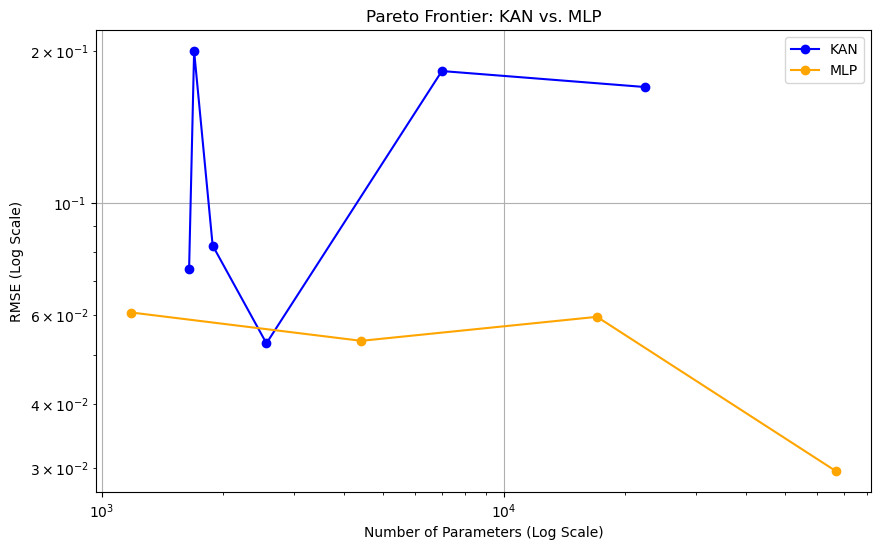

In [22]:
# Sort the KAN results by the number of parameters
kan_sorted_indices = np.argsort(kan_params_list)
kan_params_sorted = np.array(kan_params_list)[kan_sorted_indices]
kan_rmse_sorted = np.array(kan_rmse_list)[kan_sorted_indices]

# Sort the MLP results by the number of parameters
mlp_sorted_indices = np.argsort(mlp_params_list)
mlp_params_sorted = np.array(mlp_params_list)[mlp_sorted_indices]
mlp_rmse_sorted = np.array(mlp_rmse_list)[mlp_sorted_indices]

# Plot with lines and points
plt.figure(figsize=(10, 6))
plt.plot(kan_params_sorted, kan_rmse_sorted, 'o-', label="KAN", color='blue')  # Line with points
plt.plot(mlp_params_sorted, mlp_rmse_sorted, 'o-', label="MLP", color='orange')  # Line with points
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of Parameters (Log Scale)")
plt.ylabel("RMSE (Log Scale)")
plt.title("Pareto Frontier: KAN vs. MLP")
plt.legend()
plt.grid(True)
plt.show()


In [23]:
from sklearn.metrics import mean_squared_error

kan_params_list = []
kan_train_rmse_list = []
kan_test_rmse_list = []

grid_points = [3, 5, 10, 20, 50, 100]  # Grid resolutions for KAN

for G in grid_points:
    # Define and compile KAN
    kan_model = KolmogorovArnoldNetwork(
        input_dim=2, num_outer=5, hidden_units_inner=G, hidden_units_outer=16
    )
    kan_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    
    # Train the model
    print(f"Training KAN with grid resolution G={G}")
    kan_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    
    # Evaluate on training set
    y_train_pred = kan_model.predict(X_train)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    kan_train_rmse_list.append(train_rmse)
    
    # Evaluate on test set
    y_test_pred = kan_model.predict(X_test)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    kan_test_rmse_list.append(test_rmse)
    
    # Track number of parameters
    kan_params = kan_model.count_params()
    kan_params_list.append(kan_params)
    print(f"G={G}, Train RMSE={train_rmse:.6f}, Test RMSE={test_rmse:.6f}, Parameters={kan_params}")


Training KAN with grid resolution G=3
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
G=3, Train RMSE=0.195915, Test RMSE=0.199299, Parameters=1649
Training KAN with grid resolution G=5


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
G=5, Train RMSE=0.045485, Test RMSE=0.053831, Parameters=1697
Training KAN with grid resolution G=10


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
G=10, Train RMSE=0.181995, Test RMSE=0.186118, Parameters=1887
Training KAN with grid resolution G=20


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
G=20, Train RMSE=0.043702, Test RMSE=0.051848, Parameters=2567
Training KAN with grid resolution G=50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
G=50, Train RMSE=0.062668, Test RMSE=0.069560, Parameters=7007
Training KAN with grid resolution G=100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step
G=100, Train RMSE=0.156658, Test RMSE=0.163812, Parameters=22407


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [24]:
mlp_params_list = []
mlp_train_rmse_list = []
mlp_test_rmse_list = []

mlp_configs = [(32, 32), (64, 64), (128, 128), (256, 256)]  # MLP widths and depths

for config in mlp_configs:
    # Define and train MLP
    mlp_model = MLPRegressor(hidden_layer_sizes=config, activation='relu', solver='adam', max_iter=500, random_state=42)
    mlp_model.fit(X_train, y_train)
    
    # Evaluate on training set
    y_train_pred = mlp_model.predict(X_train)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    mlp_train_rmse_list.append(train_rmse)
    
    # Evaluate on test set
    y_test_pred = mlp_model.predict(X_test)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    mlp_test_rmse_list.append(test_rmse)
    
    # Track number of parameters
    mlp_params = sum(p.size for p in mlp_model.coefs_) + sum(p.size for p in mlp_model.intercepts_)
    mlp_params_list.append(mlp_params)
    print(f"MLP Config={config}, Train RMSE={train_rmse:.6f}, Test RMSE={test_rmse:.6f}, Parameters={mlp_params}")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MLP Config=(32, 32), Train RMSE=0.060248, Test RMSE=0.060732, Parameters=1185


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MLP Config=(64, 64), Train RMSE=0.053695, Test RMSE=0.053391, Parameters=4417


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MLP Config=(128, 128), Train RMSE=0.062688, Test RMSE=0.059550, Parameters=17025
MLP Config=(256, 256), Train RMSE=0.028465, Test RMSE=0.029513, Parameters=66817


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


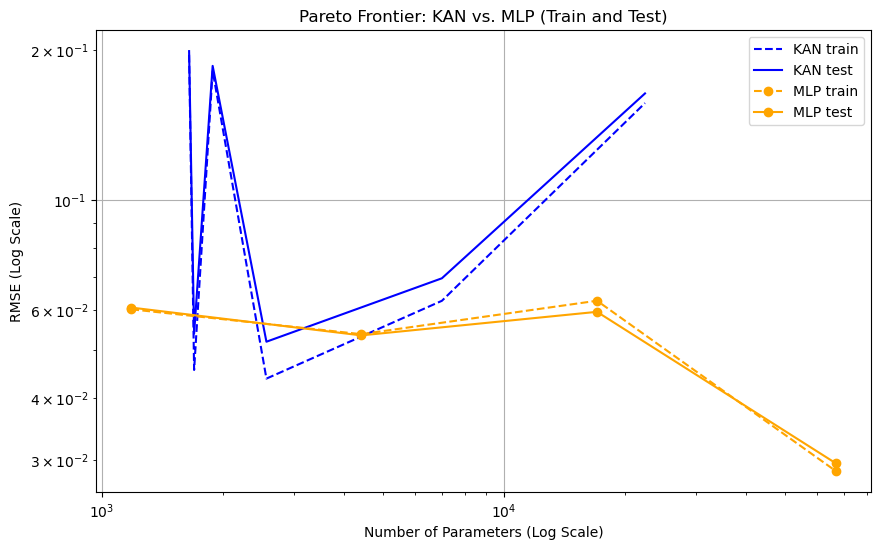

In [26]:
plt.figure(figsize=(10, 6))

# Sort and plot KAN results
kan_sorted_indices = np.argsort(kan_params_list)
kan_params_sorted = np.array(kan_params_list)[kan_sorted_indices]
kan_train_sorted = np.array(kan_train_rmse_list)[kan_sorted_indices]
kan_test_sorted = np.array(kan_test_rmse_list)[kan_sorted_indices]

plt.plot(kan_params_sorted, kan_train_sorted, 'b--', label="KAN train")  # KAN Train
plt.plot(kan_params_sorted, kan_test_sorted, 'b-', label="KAN test")    # KAN Test

# Sort and plot MLP results
mlp_sorted_indices = np.argsort(mlp_params_list)
mlp_params_sorted = np.array(mlp_params_list)[mlp_sorted_indices]
mlp_train_sorted = np.array(mlp_train_rmse_list)[mlp_sorted_indices]
mlp_test_sorted = np.array(mlp_test_rmse_list)[mlp_sorted_indices]

plt.plot(mlp_params_sorted, mlp_train_sorted, 'o--', color='orange', label="MLP train")  # MLP Train
plt.plot(mlp_params_sorted, mlp_test_sorted, 'o-', color='orange', label="MLP test")    # MLP Test

# Formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of Parameters (Log Scale)")
plt.ylabel("RMSE (Log Scale)")
plt.title("Pareto Frontier: KAN vs. MLP (Train and Test)")
plt.legend()
plt.grid(True)
plt.show()


In [27]:
from scipy.special import ellipj
import numpy as np

def generate_ellipj_dataset(n_samples=5000):
    np.random.seed(42)
    u = np.random.uniform(0, 10, n_samples)  # Amplitude
    m = np.random.uniform(0, 1, n_samples)  # Modulus
    y = np.array([ellipj(ui, mi)[0] for ui, mi in zip(u, m)])  # sn(u|m)
    return np.vstack([u, m]).T, y


In [28]:
from scipy.special import lpmv

def generate_legendre_dataset(n_samples=5000, m=1, n=2):
    np.random.seed(42)
    x = np.random.uniform(-1, 1, n_samples)  # x in [-1, 1]
    y = lpmv(m, n, x)  # P^m_n(x)
    return x.reshape(-1, 1), y


In [29]:
from scipy.special import sph_harm

def generate_sph_harm_dataset(n_samples=5000, m=0, n=1):
    np.random.seed(42)
    theta = np.random.uniform(0, np.pi, n_samples)  # Polar angle θ
    phi = np.random.uniform(0, 2 * np.pi, n_samples)  # Azimuthal angle φ
    y = np.abs(sph_harm(m, n, phi, theta))  # Absolute value of Y^m_n(θ, φ)
    return np.vstack([theta, phi]).T, y


In [30]:
from sklearn.model_selection import train_test_split

def split_data(X, y):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test


In [31]:
from sklearn.metrics import mean_squared_error

def train_kan(X_train, y_train, X_val, y_val, X_test, y_test, grid_points):
    kan_params_list, kan_train_rmse_list, kan_test_rmse_list = [], [], []
    
    for G in grid_points:
        kan_model = KolmogorovArnoldNetwork(input_dim=X_train.shape[1], num_outer=5, 
                                            hidden_units_inner=G, hidden_units_outer=16)
        kan_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
        
        # Train the model
        kan_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=0)
        
        # Train RMSE
        y_train_pred = kan_model.predict(X_train)
        train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
        
        # Test RMSE
        y_test_pred = kan_model.predict(X_test)
        test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
        
        # Store results
        kan_params = kan_model.count_params()
        kan_params_list.append(kan_params)
        kan_train_rmse_list.append(train_rmse)
        kan_test_rmse_list.append(test_rmse)
    
    return kan_params_list, kan_train_rmse_list, kan_test_rmse_list


In [32]:
from sklearn.neural_network import MLPRegressor

def train_mlp(X_train, y_train, X_test, y_test, mlp_configs):
    mlp_params_list, mlp_train_rmse_list, mlp_test_rmse_list = [], [], []
    
    for config in mlp_configs:
        mlp_model = MLPRegressor(hidden_layer_sizes=config, activation='relu', 
                                 solver='adam', max_iter=500, random_state=42)
        mlp_model.fit(X_train, y_train)
        
        # Train RMSE
        y_train_pred = mlp_model.predict(X_train)
        train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
        
        # Test RMSE
        y_test_pred = mlp_model.predict(X_test)
        test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
        
        # Store results
        mlp_params = sum(p.size for p in mlp_model.coefs_) + sum(p.size for p in mlp_model.intercepts_)
        mlp_params_list.append(mlp_params)
        mlp_train_rmse_list.append(train_rmse)
        mlp_test_rmse_list.append(test_rmse)
    
    return mlp_params_list, mlp_train_rmse_list, mlp_test_rmse_list


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

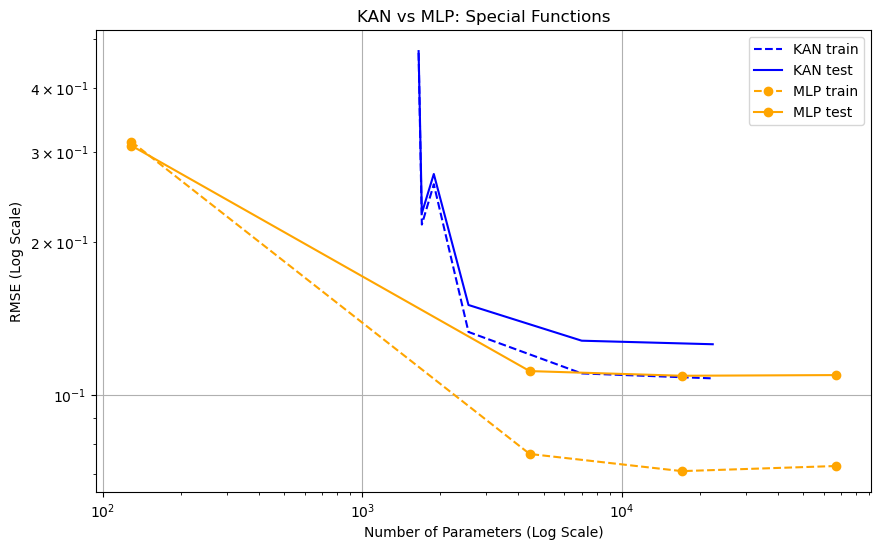

In [33]:
# Generate Data
X, y = generate_ellipj_dataset()  # Replace with desired function
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

# KAN Grid Sweep
grid_points = [3, 5, 10, 20, 50, 100]
kan_params, kan_train_rmse, kan_test_rmse = train_kan(X_train, y_train, X_val, y_val, X_test, y_test, grid_points)

# MLP Configurations Sweep
mlp_configs = [(32,), (64, 64), (128, 128), (256, 256)]
mlp_params, mlp_train_rmse, mlp_test_rmse = train_mlp(X_train, y_train, X_test, y_test, mlp_configs)

# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(kan_params, kan_train_rmse, 'b--', label="KAN train")
plt.plot(kan_params, kan_test_rmse, 'b-', label="KAN test")
plt.plot(mlp_params, mlp_train_rmse, 'o--', color='orange', label="MLP train")
plt.plot(mlp_params, mlp_test_rmse, 'o-', color='orange', label="MLP test")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of Parameters (Log Scale)")
plt.ylabel("RMSE (Log Scale)")
plt.title("KAN vs MLP: Special Functions")
plt.legend()
plt.grid(True)
plt.show()


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

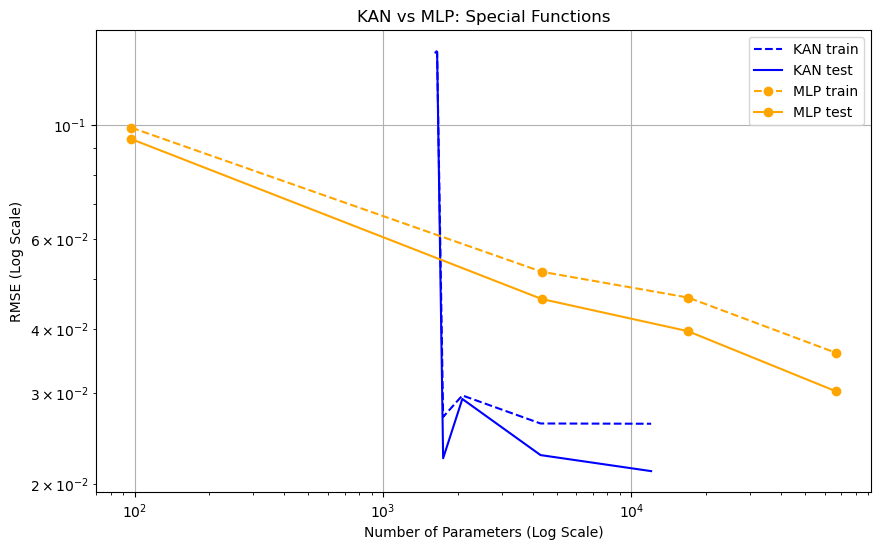

In [34]:
# Generate Data
X, y = generate_legendre_dataset()  # Replace with desired function
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

# KAN Grid Sweep
grid_points = [3, 5, 10, 20, 50, 100]
kan_params, kan_train_rmse, kan_test_rmse = train_kan(X_train, y_train, X_val, y_val, X_test, y_test, grid_points)

# MLP Configurations Sweep
mlp_configs = [(32,), (64, 64), (128, 128), (256, 256)]
mlp_params, mlp_train_rmse, mlp_test_rmse = train_mlp(X_train, y_train, X_test, y_test, mlp_configs)

# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(kan_params, kan_train_rmse, 'b--', label="KAN train")
plt.plot(kan_params, kan_test_rmse, 'b-', label="KAN test")
plt.plot(mlp_params, mlp_train_rmse, 'o--', color='orange', label="MLP train")
plt.plot(mlp_params, mlp_test_rmse, 'o-', color='orange', label="MLP test")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of Parameters (Log Scale)")
plt.ylabel("RMSE (Log Scale)")
plt.title("KAN vs MLP: Special Functions")
plt.legend()
plt.grid(True)
plt.show()


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

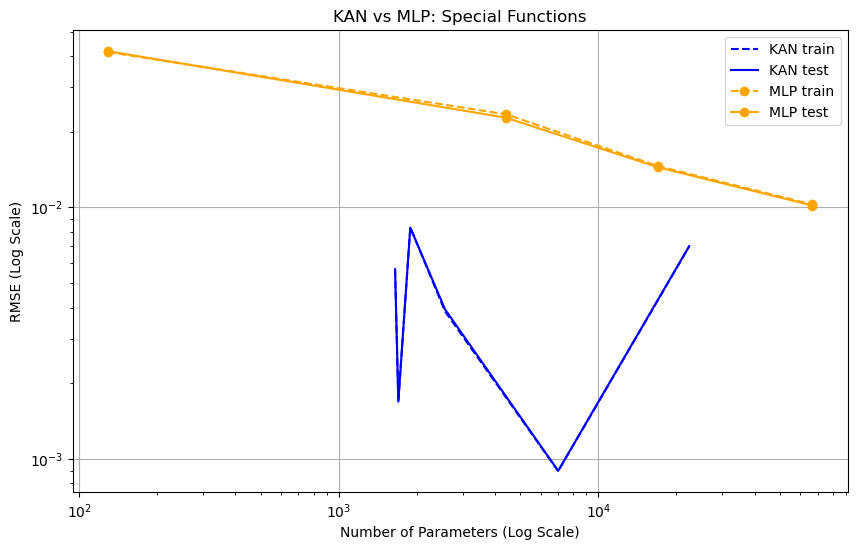

In [35]:
# Generate Data
X, y = generate_sph_harm_dataset()  # Replace with desired function
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

# KAN Grid Sweep
grid_points = [3, 5, 10, 20, 50, 100]
kan_params, kan_train_rmse, kan_test_rmse = train_kan(X_train, y_train, X_val, y_val, X_test, y_test, grid_points)

# MLP Configurations Sweep
mlp_configs = [(32,), (64, 64), (128, 128), (256, 256)]
mlp_params, mlp_train_rmse, mlp_test_rmse = train_mlp(X_train, y_train, X_test, y_test, mlp_configs)

# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(kan_params, kan_train_rmse, 'b--', label="KAN train")
plt.plot(kan_params, kan_test_rmse, 'b-', label="KAN test")
plt.plot(mlp_params, mlp_train_rmse, 'o--', color='orange', label="MLP train")
plt.plot(mlp_params, mlp_test_rmse, 'o-', color='orange', label="MLP test")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of Parameters (Log Scale)")
plt.ylabel("RMSE (Log Scale)")
plt.title("KAN vs MLP: Special Functions")
plt.legend()
plt.grid(True)
plt.show()
